<div style="text-align:center">
    <h1>
        Off-policy Monte Carlo Control
    </h1>
</div>
<br>

In this notebook we are going to implement the other of the two major strategies that exist when learning a policy by interacting with the environment, called off-policy learning. We will use two policies: 
    
- An exploratory policy called b: it will collect the experience we will use in the learning process
    
- A target policy that will learn from the experience collected by b, called $\pi$: to be optimized



## Import the necessary software libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from envs import Maze
from utils import plot_policy, plot_action_values, test_agent

/Users/liziyue/opt/anaconda3/envs/bmrl/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')


## Initialize the environment

In [2]:
env = Maze()

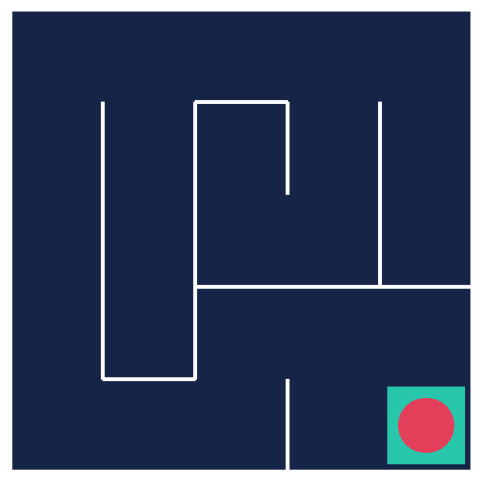

In [3]:
frame = env.render(mode='rgb_array')
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(frame)

In [4]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


## Define value table $Q(s, a)$

#### Create the $Q(s, a)$ table

In [7]:
# the initial value can ba arbitrary and following the learning process, the entries will be optimized. 
action_values = np.full((5,5,4), -100)

# to make sure the values at the goal (finding the exit (4,4)) is zero
action_values[4,4,:] = 0

#### Plot $Q(s, a)$

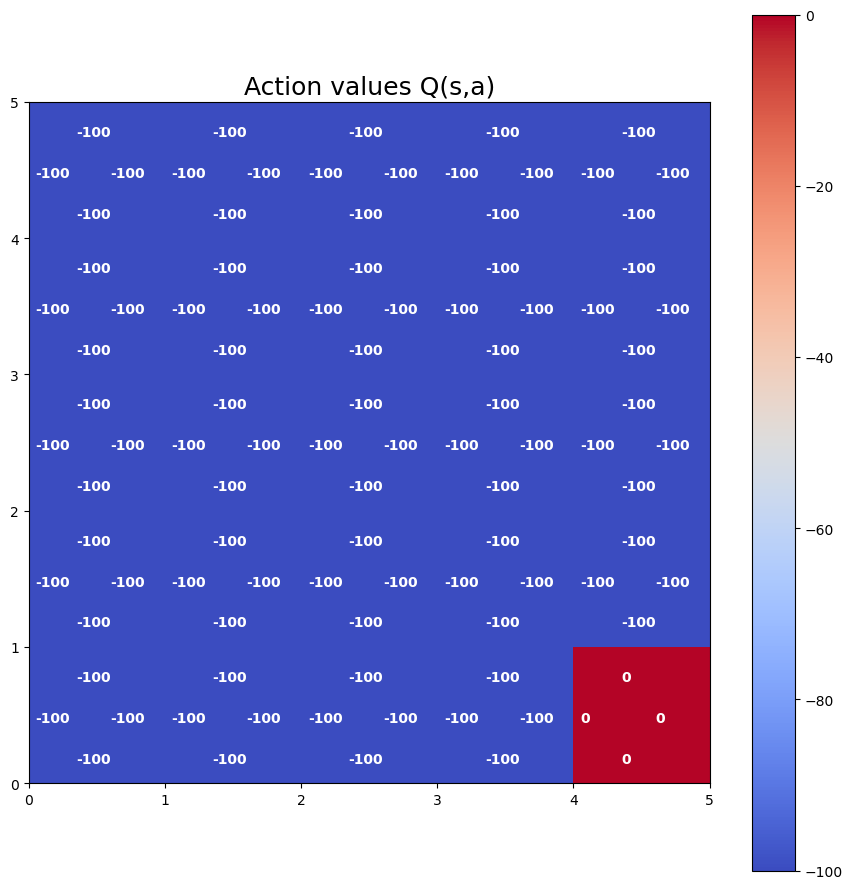

In [8]:
plot_action_values(action_values)

## Define the target policy $\pi(s)$

#### Create the policy $\pi(s)$

In [9]:
def target_policy(state):
    # av in dimension 4, with each entry as the Q-value of each action at that state
    av = action_values[state] 
    
    # in case there is a tie between multiple actions, we choose it randomly everytime we call the policy
    return np.random.choice(np.flatnonzero(av == av.max())) 

#### Test the policy with state (0, 0)

In [10]:
action = target_policy((0,0))
print(f'Action taken in state (0,0): {action}')

Action taken in state (0,0): 2


#### Plot the policy

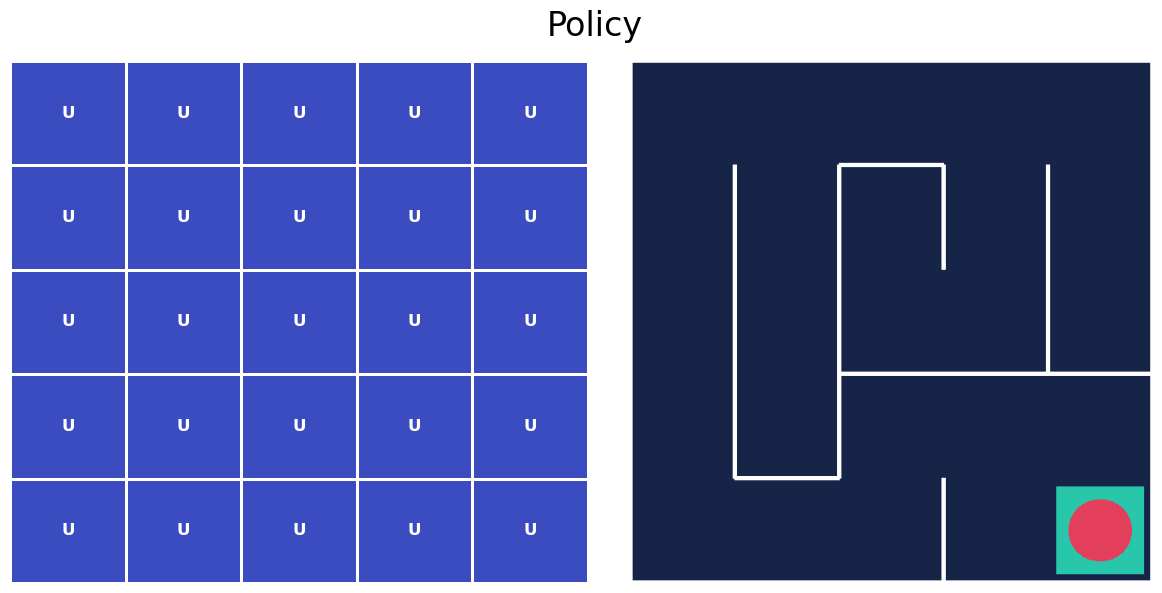

In [11]:
plot_policy(action_values, frame)

## Define the exploratory policy $b(s)$

#### Create the policy $b(s)$
- it is the policy to explore the environment
- it will explore sometimes with a certain probability to pick a random action; and at the rest of the time, it will pick the action with the highest estimated value, just as the target policy would do. 
- the greedy part (choosing the max) covers the target policy, the random action covers the range outside of target policy

In [12]:
def exploratory_policy(state, epsilon = 0.):
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

#### Test the policy with state (0, 0)

In [14]:
action = exploratory_policy((0,0), epsilon = 0.5) # giving it 50% chance
print(f'Action taken in state (0,0): {action}')

Action taken in state (0,0): 1


## Implement the algorithm

- the value table C(s,a), so that we can use them to normalize the important sampling ratio

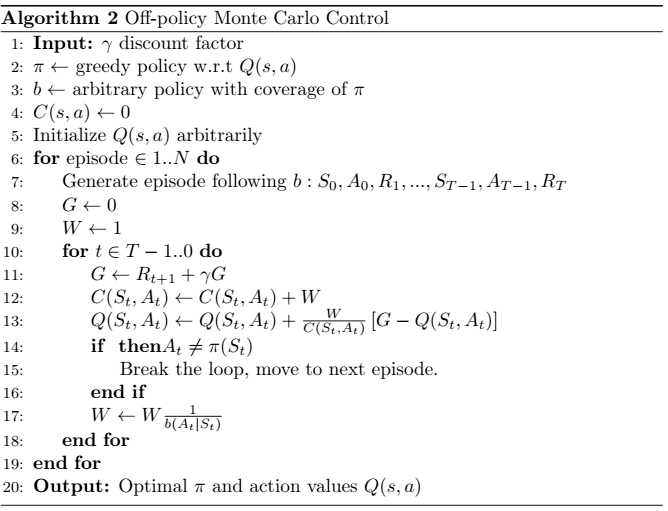

</br>



<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>

In [15]:
def off_policy_mc_control(action_values, target_policy, exploratory_policy, episodes, gamma=0.99, epsilon=0.2):
    
    csa = np.zeros((5,5,4))
    
    for episode in range(1, episodes + 1):
        G = 0
        W = 1
        state = env.reset()
        done = False
        transitions = []
        
        # To explore the environment
        while not done:
            action = exploratory_policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            transitions.append([state, action, reward])
            state = next_state
            
        # To learn the policy
        for state_t, action_t,  reward_t in reversed(transitions):
            G  = reward_t + gamma * G
            csa[state_t][action_t] += W
            qsa = action_values[state_t][action_t]
            action_values[state_t][action_t] += (W / csa[state_t][action_t]) * (G - qsa)
            
            # now we need to know if the action picked by the exploratory policy is 
            # the same as that the target policy would have picked after being updated
            if action_t != target_policy(state_t):
                break
            
            W = W * 1. / (1 - epsilon + epsilon / 4) 
            # if the action_t is the target policy will pick, then the probability is epsilon / 4; 
            # in case the action_t do not take the random aciton, i.e., taking the action with highest Q value w.p. 1 - epsilon
    

In [16]:
off_policy_mc_control(action_values, target_policy, exploratory_policy, episodes = 1000, epsilon = 0.3)

## Show results

#### Show resulting value table $Q(s, a)$

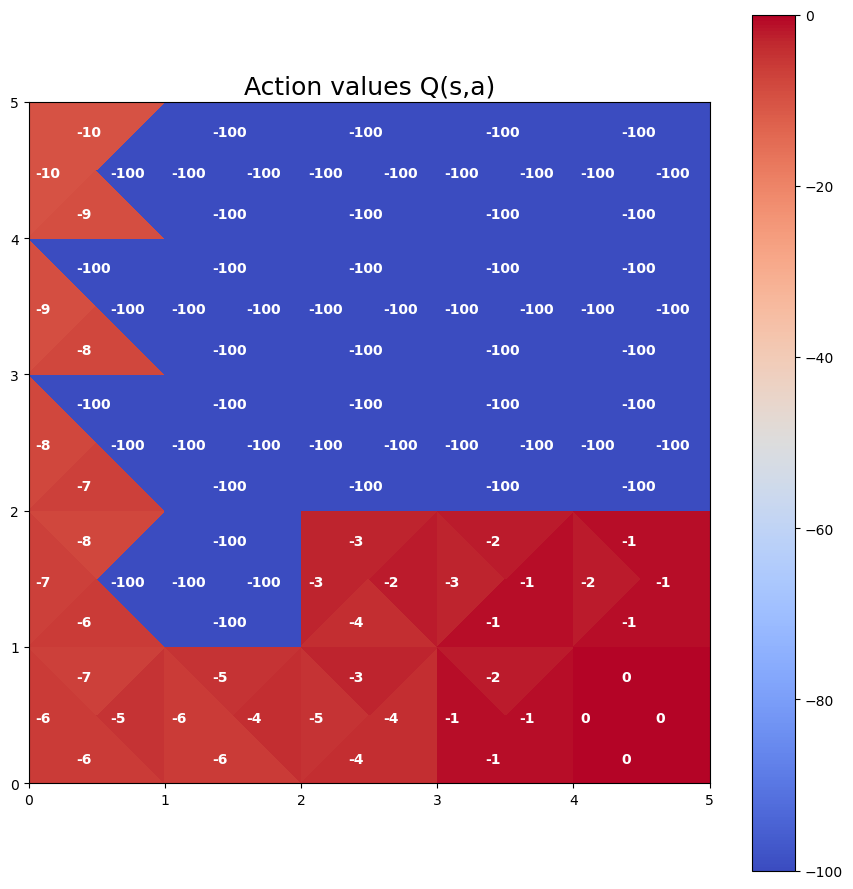

In [17]:
plot_action_values(action_values)
# the actions that bring us to the goal have the highest Q value.

# pay attention to the fact that the states that are not part of the optimal path have been practically ignored.

# one of the advantages of using methods to learn based on experience is that we can focus our efforts 
# on states and actions that lead us to solving the task in the optimal way.

# our algorithm hasn't spent much time and effort in refining the estimated of those states that do not lead to the goal.

#### Show resulting policy $\pi(\cdot|s)$

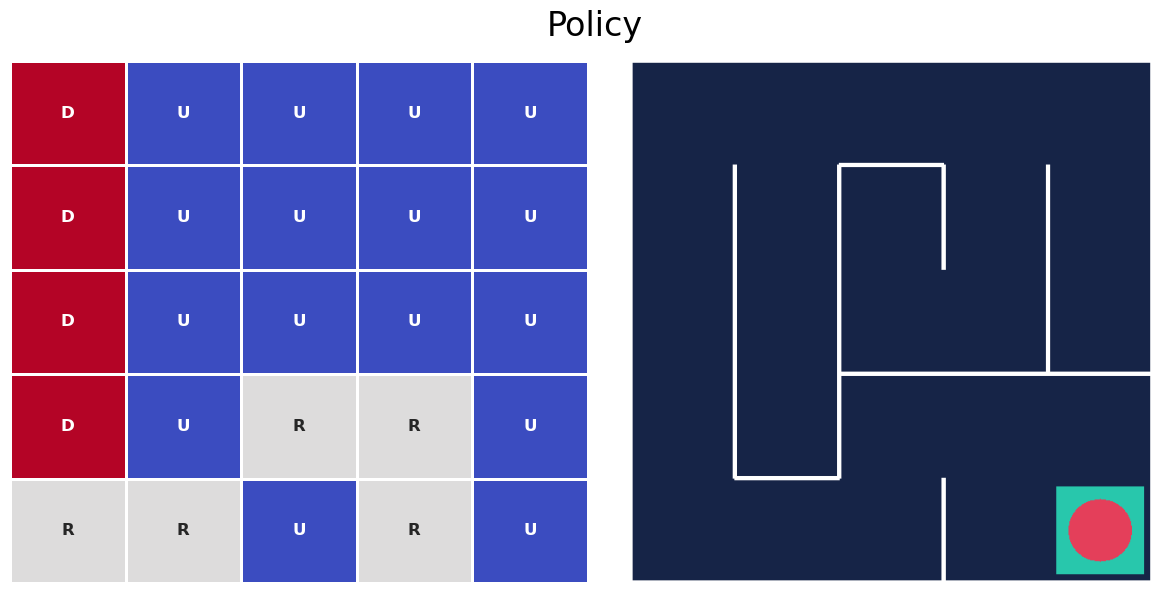

In [18]:
plot_policy(action_values, frame)
# in the section of dynamic programming, waht we did is sweeping through the whole state space, improving each of them.
# although that gave us the optimal policy and q-value table, it's extremely inefficient because we waste a lot of time
# in the states that won't help us to achieve our goals

#### Test the resulting agent

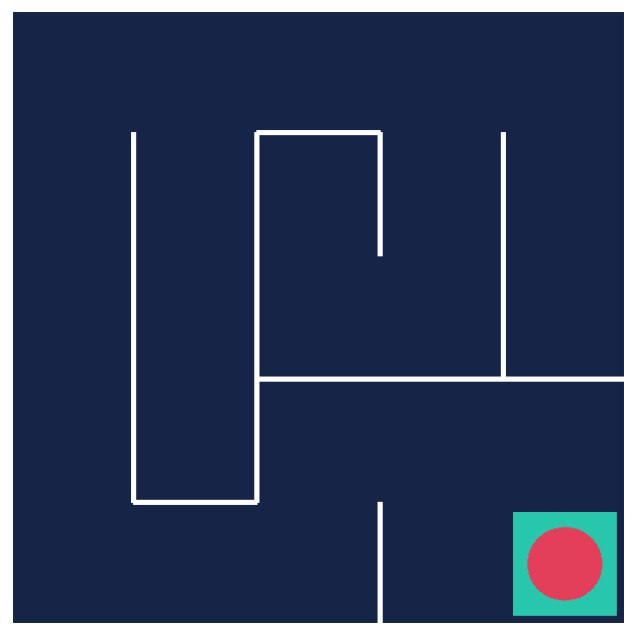

In [19]:
test_agent(env, target_policy)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch. 5: Monte Carlo methods](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)